## Test a random forest model on full dataset

In [1]:
## Python packages - you may have to pip install sqlalchemy, sqlalchemy_utils, and psycopg2.

import pandas as pd
# Make the graphs a bit prettier, and bigger
pd.set_option('display.mpl_style', 'default')

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 20)

import numpy as np
import math
# The usual preamble
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
plt.rcParams['axes.color_cycle'] = ['r', 'g', 'b', 'c']
plt.rcParams['lines.color'] = 'r'
plt.rcParams['figure.figsize'] = (15, 5)

import process
from modeling import categorize

Populating the interactive namespace from numpy and matplotlib


/Users/along528/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Load in dataset

In [27]:
test_data,val_data = process.get_split_add_data()
val_data

,total,urban,rural,institutionalized_all,institutionalized_adult_all,institutionalized_adult_federal_detention_all,institutionalized_adult_federal_prison_all,institutionalized_adult_state_prison_all,institutionalized_adult_local_jail_all,institutionalized_juvenile_all,institutionalized_white,institutionalized_adult_white,institutionalized_adult_federal_detention_white,institutionalized_adult_federal_prison_white,institutionalized_adult_state_prison_white,institutionalized_adult_local_jail_white,institutionalized_juvenile_white,institutionalized_black,institutionalized_adult_black,institutionalized_adult_federal_detention_black,institutionalized_adult_federal_prison_black,institutionalized_adult_state_prison_black,institutionalized_adult_local_jail_black,institutionalized_juvenile_black,population_white,population_black,total_income_estimate_all,total_income_estimate_white,total_income_estimate_black,swnauthemp,...,chiefmax_per_capita,sgtmin_per_capita,sgtmax_per_capita,entrymin_per_capita,entrymax_per_capita,nummrkcars_per_capita,numothmrk_per_capita,numumkcars_per_capita,numothunm_per_capita,numplanes_per_capita,numcopters_per_capita,numboats_per_capita,nummotor_per_capita,numcarcam_per_capita,numfixcam_per_capita,nummobcam_per_capita,population_per_capita,rpsi,black_over_white_population_disparity,black_over_white_income_disparity,black_over_white_institutionalized_disparity,black_over_white_institutionalized_adult_disparity,black_over_white_institutionalized_adult_federal_detention_disparity,black_over_white_institutionalized_adult_federal_prison_disparity,black_over_white_institutionalized_adult_state_prison_disparity,black_over_white_institutionalized_adult_local_jail_disparity,black_over_white_institutionalized_juvenile_disparity,black_officer_disparity,white_officer_disparity,black_over_white_officer_disparity
surveyid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1222,26647,26616,31,186,0,0,0,0,0,13,144,0,0,0,0,0,5,37,0,0,0,0,0,6,24649,323,9712,9063,35,65,...,4.943333,2.824183,2.965287,1.670695,2.456337,0.000675,0.000150,0.000450,0.000150,0,0.000000,0.000075,0.000038,0.000075,0.000525,0.000000,1.002139,3.067020,0.013104,0.003862,0.256944,1.000000,1,1.000000,1.000000,1.000000,1.200000,0.000000,1.031163,0.000000
184,110372,110372,0,1149,219,0,0,0,0,44,861,83,0,0,0,0,23,209,82,0,0,0,0,13,64836,22146,40950,26944,7822,300,...,1.032871,0.576197,0.587504,0.406117,0.414127,0.001196,0.000190,0.000734,0.000136,0,0.000000,0.000000,0.000082,0.000000,0.000027,0.000027,0.971632,1.356672,0.341569,0.290306,0.242741,0.987952,1,1.000000,1.000000,1.000000,0.565217,0.348868,1.361861,0.256170
175,123919,123919,0,2194,1277,0,0,0,1095,119,1027,378,0,0,0,309,46,683,512,0,0,0,436,46,36606,48114,46061,17050,17580,592,...,1.129770,0.541951,0.579822,0.331822,0.499568,0.001477,0.000234,0.000912,0.000169,0,0.000000,0.000024,0.000105,0.000347,0.000016,0.000000,1.005157,1.708121,1.314375,1.031085,0.665044,1.354497,1,1.000000,1.000000,1.411003,1.000000,0.389109,2.118801,0.183646
1214,8373,4821,3552,147,0,0,0,0,0,0,145,0,0,0,0,0,0,1,0,0,0,0,0,0,7866,79,3018,2874,19,19,...,7.643616,6.329870,6.329870,5.587006,6.324137,0.000597,0.000239,0.000478,0.000000,0,0.000000,0.000000,0.000000,0.000597,0.000000,0.000000,1.855727,3.972093,0.010043,0.006611,0.006897,1.000000,1,1.000000,1.000000,1.000000,1.000000,0.000000,0.827909,0.000000
170,80882,78229,2653,1904,1341,0,1339,0,0,25,1162,637,0,637,0,0,17,434,406,0,406,0,0,7,55191,5803,29034,21017,1763,152,...,1.344082,0.831322,0.856433,0.596734,0.765881,0.000519,0.000111,0.000334,0.000074,0,0.000000,0.000012,0.000000,0.000000,0.000000,0.000000,0.987772,1.210668,0.105144,0.083884,0.373494,0.637363,1,0.637363,1.000000,1.000000,0.411765,0.376702,1.307061,0.288205
174,60966,59531,1435,427,0,0,0,0,0,82,363,0,0,0,0,0,43,53,0,0,0,0,0,28,41750,12292,23342,16691,4492,107,...,1.512157,1.170128,1.170128,0.796690,1.060739,0.000377,0.000098,0.000328,0.000066,0,0.000000,0.000000,0.000066,0.000197,0.000000,0.000016,0.

In [28]:
val_data.to_sql('val_data',process.engine,if_exists='replace')



# Build Model

In [30]:
processor = process.Processor(val_data)
X_val,y_val_cat = processor.get_scaled_Xy(val_data)
X_test,y_test_cat = processor.get_scaled_Xy(test_data)

In [31]:
test_data

,total,urban,rural,institutionalized_all,institutionalized_adult_all,institutionalized_adult_federal_detention_all,institutionalized_adult_federal_prison_all,institutionalized_adult_state_prison_all,institutionalized_adult_local_jail_all,institutionalized_juvenile_all,institutionalized_white,institutionalized_adult_white,institutionalized_adult_federal_detention_white,institutionalized_adult_federal_prison_white,institutionalized_adult_state_prison_white,institutionalized_adult_local_jail_white,institutionalized_juvenile_white,institutionalized_black,institutionalized_adult_black,institutionalized_adult_federal_detention_black,institutionalized_adult_federal_prison_black,institutionalized_adult_state_prison_black,institutionalized_adult_local_jail_black,institutionalized_juvenile_black,population_white,population_black,total_income_estimate_all,total_income_estimate_white,total_income_estimate_black,swnauthemp,...,chiefmax_per_capita,sgtmin_per_capita,sgtmax_per_capita,entrymin_per_capita,entrymax_per_capita,nummrkcars_per_capita,numothmrk_per_capita,numumkcars_per_capita,numothunm_per_capita,numplanes_per_capita,numcopters_per_capita,numboats_per_capita,nummotor_per_capita,numcarcam_per_capita,numfixcam_per_capita,nummobcam_per_capita,population_per_capita,rpsi,black_over_white_population_disparity,black_over_white_income_disparity,black_over_white_institutionalized_disparity,black_over_white_institutionalized_adult_disparity,black_over_white_institutionalized_adult_federal_detention_disparity,black_over_white_institutionalized_adult_federal_prison_disparity,black_over_white_institutionalized_adult_state_prison_disparity,black_over_white_institutionalized_adult_local_jail_disparity,black_over_white_institutionalized_juvenile_disparity,black_officer_disparity,white_officer_disparity,black_over_white_officer_disparity
surveyid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
353,117295,114240,3055,1048,0,0,0,0,0,41,770,0,0,0,0,0,15,231,0,0,0,0,0,23,79644,8083,37822,27914,2693,189,...,1.259491,0.605831,0.811876,0.441980,0.607639,0.000614,0.000094,0.000384,0.000077,0,0,0.000000,0.000077,0.000597,0.000000,0.000034,0.877787,3.314577,0.101489,0.096475,0.300000,1.000000,1,1,1.000000,1.000000,1.533333,1.074913,1.114296,0.964656
1473,19852,19852,0,159,0,0,0,0,0,0,62,0,0,0,0,0,0,96,0,0,0,0,0,0,14715,3704,7260,5512,1509,58,...,5.731009,3.705873,3.876133,2.256246,3.530476,0.000554,0.000201,0.000705,0.000201,0,0,0.000000,0.000000,0.000504,0.000101,0.000000,0.982269,2.686244,0.251716,0.273766,1.548387,1.000000,1,1,1.000000,1.000000,1.000000,0.287122,1.204553,0.238364
2155,9453,9453,0,98,0,0,0,0,0,0,76,0,0,0,0,0,0,21,0,0,0,0,0,0,6084,1815,3869,2895,683,36,...,9.520787,4.443034,6.770337,4.019888,6.135618,0.003279,0.000106,0.001375,0.000212,0,0,0.000000,0.000000,0.002962,0.000000,0.000000,0.404739,3.581837,0.298323,0.235924,0.276316,1.000000,1,1,1.000000,1.000000,1.000000,0.289348,1.424269,0.203156
2110,9913,2798,7115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8538,538,3723,3320,279,8,...,5.548270,3.833350,3.934228,2.622819,2.925451,0.001110,0.000101,0.000202,0.000202,0,0,0.000000,0.000000,0.001009,0.000000,0.000000,0.113689,2.255095,0.063012,0.084036,1.000000,1.000000,1,1,1.000000,1.000000,1.000000,0.000000,1.161045,0.000000
1521,6116,4172,1944,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5862,46,2123,2096,9,10,...,12.262917,8.168574,9.460432,5.174460,7.140288,0.000981,0.000000,0.000327,0.000000,0,0,0.000000,0.000000,0.000654,0.000000,0.000164,0.694245,2.386727,0.007847,0.004294,1.000000,1.000000,1,1,1.000000,1.000000,1.000000,0.000000,1.043330,0.000000
2128,33307,29497,3810,22,0,0,0,0,0,0,11,0,0,0,0,0,0,11,0,0,0,0,0,0,20727,8942,12068,7802,3403,30,...,2.172186,0.985649,1.392710,0.892875,1.261657,0.000360,0.000030,0.000180,0.000000,0,0,0.000000,0.000000,0.000150,0.000000,0.000000,0.383643,0.466930,0.431418,0.436170,1.000000,1.000000,1,1,1.000000,1.000000,1.000000,0.128441,1.496115,0.085850
1503,10548,7109,3439,0,0,0,0,0,0,0,0,0,0,0,0,

In [32]:
val_data_scaled = pd.DataFrame(np.c_[X_val,y_val_cat],index=val_data.index,columns=val_data.drop('rpsi',1).columns.tolist()+['rpsi'])
val_data_scaled.to_sql('val_data_scaled',process.engine,if_exists='replace')#print X_val+y_val

(array([ 10.,   2.,   1.,   0.,   7.,  10.,   6.,  12.,  13.,  13.,  14.,
         11.,  10.,  11.,  14.,   7.,   9.,   4.,   4.,   0.,   4.,   3.,
          0.,   1.,   2.,   1.,   0.,   1.,   0.,   0.,   1.,   1.,   1.,
          0.,   1.,   0.,   1.,   2.,   0.,   1.]),
 array([ 0.        ,  0.18557692,  0.37115385,  0.55673077,  0.74230769,
         0.92788462,  1.11346154,  1.29903846,  1.48461538,  1.67019231,
         1.85576923,  2.04134615,  2.22692308,  2.4125    ,  2.59807692,
         2.78365385,  2.96923077,  3.15480769,  3.34038462,  3.52596154,
         3.71153846,  3.89711538,  4.08269231,  4.26826923,  4.45384615,
         4.63942308,  4.825     ,  5.01057692,  5.19615385,  5.38173077,
         5.56730769,  5.75288462,  5.93846154,  6.12403846,  6.30961538,
         6.49519231,  6.68076923,  6.86634615,  7.05192308,  7.2375    ,
         7.42307692]),
 <a list of 40 Patch objects>)

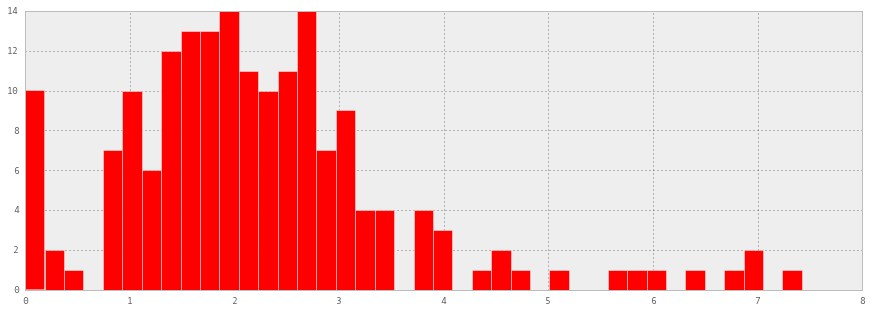

In [33]:
plt.hist(val_data['rpsi'].tolist(),bins=40)

In [34]:
for cat in sort(val_data_scaled['rpsi'].unique().tolist()):
    
    print cat, shape(val_data_scaled[val_data_scaled['rpsi']==cat])[0]

0.0 37
1.0 75
2.0 66


In [35]:
from sklearn import linear_model,cross_validation,metrics,grid_search

from sklearn.ensemble import RandomForestClassifier
values = range(10,80,10)
n_iter = len(values)
param_grid = {'n_estimators': values,
             'max_features': values}
clf = RandomForestClassifier(n_jobs=2)
clfmodel = grid_search.RandomizedSearchCV(clf,param_grid,
                                          n_iter*n_iter,cv=5,verbose=1,random_state=2)
clfmodel.fit(X_val,y_val_cat)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   17.8s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  1.3min


Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:  1.6min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=49, n_jobs=1,
          param_distributions={'n_estimators': [10, 20, 30, 40, 50, 60, 70], 'max_features': [10, 20, 30, 40, 50, 60, 70]},
          pre_dispatch='2*n_jobs', random_state=2, refit=True,
          scoring=None, verbose=1)

In [36]:
print clfmodel.best_params_
print clfmodel.best_score_
features = []
importances = []
for feature,importance in zip(val_data.drop('rpsi',1).columns.tolist(),clfmodel.best_estimator_.feature_importances_):
    #print feature,importance
    features.append(feature)
    importances.append(importance)
indices = [i[0] for i in sorted(enumerate(importances), key=lambda x:x[1])]
best_feature_names = []
for index in reversed(indices):
    print features[index],importances[index]
    if importances[index] < 0.005:
        continue
    best_feature_names.append(features[index])
print len(best_feature_names)

{'n_estimators': 10, 'max_features': 60}
0.398876404494
sgtmax 0.0395140880107
ptreserveswn_per_capita 0.028845501386
rural_per_capita 0.0244917401964
chiefmin 0.0229191566608
entrymin 0.0225496809211
rural 0.022539054774
institutionalized_adult_local_jail_white_per_capita 0.0215659012939
institutionalized_black_per_capita 0.0212783951953
totptemp 0.0209601853755
total_income_estimate_white_per_capita 0.0209140168886
drugforf_per_capita 0.0206998729493
entrymax 0.0198389750259
white_per_capita 0.0198257911503
urban_per_capita 0.0193278044094
numfixcam_per_capita 0.0172051104117
chiefmax 0.0171664152652
numothunm_per_capita 0.0171407000277
opbudget_per_capita 0.0170469604991
numpatr_per_capita 0.0161894922148
institutionalized_adult_white 0.0157661822753
civptemp_per_capita 0.0152076827289
numumkcars_per_capita 0.0149524208443
black_over_white_institutionalized_juvenile_disparity 0.0139988090626
numsro_per_capita 0.013624044023
sgtmin 0.0134923379258
totftemp 0.0124532730823
totinsrv 0.

In [37]:
import pickle
pickle.dump(best_feature_names,open('best_features_names.p','wb'))


In [38]:
import pickle
best_features_names = pickle.load(open('best_features_names.p','rb'))
print best_features_names

['sgtmax', 'ptreserveswn_per_capita', 'rural_per_capita', 'chiefmin', 'entrymin', 'rural', 'institutionalized_adult_local_jail_white_per_capita', 'institutionalized_black_per_capita', 'totptemp', 'total_income_estimate_white_per_capita', 'drugforf_per_capita', 'entrymax', 'white_per_capita', 'urban_per_capita', 'numfixcam_per_capita', 'chiefmax', 'numothunm_per_capita', 'opbudget_per_capita', 'numpatr_per_capita', 'institutionalized_adult_white', 'civptemp_per_capita', 'numumkcars_per_capita', 'black_over_white_institutionalized_juvenile_disparity', 'numsro_per_capita', 'sgtmin', 'totftemp', 'totinsrv', 'ptreserveswn', 'numcarcam', 'totftemp_per_capita', 'institutionalized_adult_black', 'male', 'institutionalized_all_per_capita', 'black_over_white_population_disparity', 'nummrkcars_per_capita', 'institutionalized_juvenile_white', 'numrespoff', 'institutionalized_juvenile_white_per_capita', 'total_income_estimate_all_per_capita', 'institutionalized_adult_state_prison_all', 'male_per_cap

In [39]:
processor = process.Processor(val_data[best_features_names+['rpsi']])
X_val,y_val_cat = processor.get_scaled_Xy(val_data[best_features_names+['rpsi']])
X_test,y_test_cat = processor.get_scaled_Xy(test_data[best_features_names+['rpsi']])



In [40]:
from sklearn.ensemble import RandomForestClassifier
values = range(10,shape(X_val)[1],5)
n_iter = len(values)
param_grid = {'n_estimators': values,
             'max_features': values}
clf2 = RandomForestClassifier()
clfmodel2 = grid_search.RandomizedSearchCV(clf2,param_grid,
                                          n_iter*n_iter,cv=5,verbose=1,random_state=2)
clfmodel2.fit(X_val,y_val_cat)
print clfmodel2.best_params_
print clfmodel2.best_score_

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   31.7s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:  2.5min


Fitting 5 folds for each of 169 candidates, totalling 845 fits
{'n_estimators': 40, 'max_features': 15}
0.404494382022


[Parallel(n_jobs=1)]: Done 845 out of 845 | elapsed:  2.8min finished


In [43]:
est =  clfmodel2.best_estimator_
print est

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=15, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [45]:
import pickle
pickle.dump(est,open('randomforestclassifier_bad.p','wb'))

In [46]:
est = pickle.load(open('randomforestclassifier_bad.p','rb'))
print est

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=15, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [47]:
#classification
nmatch = 0
total = 0
for prediction, actual, ismatch in zip(est.predict(X_test),y_test_cat,est.predict(X_test)==y_test_cat):
    if ismatch:
        nmatch+=1
    total+=1

print "test accuracy =",float(nmatch)/float(total)
print "total",total

test accuracy = 0.413043478261
total 46


array([[ 2,  6,  3],
       [ 3, 10,  8],
       [ 0,  7,  7]])

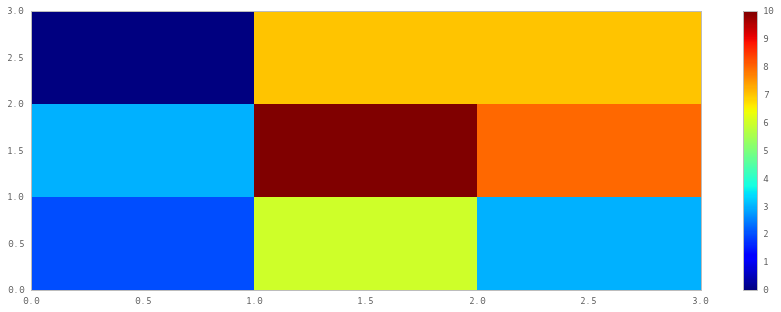

In [48]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test_cat,clfmodel2.predict(X_test))
plt.pcolor(matrix.T.T)
plt.colorbar()
matrix

In [71]:
sql_query = """
    SELECT  * FROM traffic_joined_with_features;
    """
data = add_features(get_data())

descriptors = []
descriptors = ['agency','city','state','zipcode']
test = pd.read_sql_query(sql_query,con).drop('index',axis=1)
test = test[test['surveyid'].isin(data.index.tolist())]
#test = test.merge(data,how='right',right_on='surveyid')
#data = add_features(get_data())[best_feature_names+['agency']]
#test
test = test.sort(columns='surveyid').set_index('surveyid',drop=True)
test = test[descriptors]
test
sorted_data = data.sort_index()
sorted_data = sorted_data[best_feature_names]
output = pd.concat([test,sorted_data],axis=1)
output

/Users/along528/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,agency,city,state,zipcode,entrymin,opbudget_per_capita,rural_per_capita,amerind_per_capita,population_black_per_capita,chiefmin,entrymax,total_income_estimate_all_per_capita,black_over_white_institutionalized_adult_local_jail_disparity,total_income_estimate_white_per_capita,numothmrk_per_capita,female_per_capita,nummrkcars_per_capita,urban_per_capita,swnftemp_per_capita,institutionalized_all_per_capita,opbudget,totacad,black_per_capita,black_over_white_institutionalized_disparity,population_per_capita,totinsrv_per_capita,numrespoff_per_capita,sgtmin,population_black,swnauthemp_per_capita,...,sgtmax,totptemp_per_capita,institutionalized_white_per_capita,black_over_white_income_disparity,totgender_per_capita,swnauthemp,total_income_estimate_all,chiefmax_per_capita,institutionalized_adult_local_jail_black_per_capita,chiefmin_per_capita,ftdrugoff_per_capita,institutionalized_white,numothmrk,swnptemp_per_capita,totgender,white,population,hispanic_per_capita,totfield,numcpo,urban,population_white_per_capita,swnftemp,institutionalized_juvenile_white,numothunm_per_capita,total_income_estimate_black,institutionalized_adult_white_per_capita,population_white,institutionalized_black_per_capita,nummobcam_per_capita
surveyid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
168,Bristol Police Department,Bristol,CT,06010,46307.00,198.517734,0.000695,0.000000,0.038430,87914.00,56336.00,0.416656,1.000000,0.377118,0.000116,0.000149,0.000298,0.999305,0.002035,0.010538,12000000,1040,0.000050,0.024430,1.013962,0.000331,0.001125,65073.00,2323,0.002068,...,999999.00,0.000000,0.010157,0.034655,0.002035,125,25186,1.960330,0.000000,1.454374,0.000017,614,7,0.000000,123,119,61292,0.000017,480,5,60406,0.877399,123,19,0.000083,790,0.000000,53037,0.000248,0.000000
170,Danbury Police Department,Danbury,CT,06810,48265.00,190.170693,0.032801,0.000000,0.071746,106712.00,61946.00,0.358967,1.000000,0.259848,0.000111,0.000124,0.000519,0.967199,0.001830,0.023540,15381386,880,0.000049,0.373494,0.987772,0.000247,0.001113,67239.00,5803,0.001879,...,69270.00,0.000000,0.014367,0.083884,0.001830,152,29034,1.344082,0.000000,1.319354,0.000062,1162,9,0.000000,148,132,79893,0.000136,640,0,78229,0.682364,148,17,0.000074,1763,0.007876,55191,0.005366,0.000000
171,East Hartford Police Department,East Hartford,CT,06108,48131.00,245.551489,0.000000,0.000000,0.260266,102843.00,58252.00,0.393208,1.000000,0.234009,0.000059,0.000195,0.001073,1.000000,0.002614,0.009071,12587706,662,0.000137,0.210826,0.951017,0.000390,0.001736,61141.00,13342,0.002633,...,66016.00,0.000059,0.006847,0.395632,0.002614,135,20157,2.006184,0.000000,2.006184,0.000059,351,3,0.000000,134,121,48752,0.000098,400,89,51263,0.512787,134,2,0.000098,4746,0.000000,26287,0.001444,0.000000
172,Fairfield Police Department,Fairfield,CT,06824,50826.00,236.264835,0.022681,0.000000,0.018792,110000.00,62985.00,0.337931,1.000000,0.313687,0.000109,0.000145,0.000273,0.977319,0.001963,0.015357,13000000,960,0.000036,0.030562,1.052087,0.000545,0.001090,63517.00,1034,0.001963,...,72865.00,0.001272,0.014867,0.018019,0.001963,108,18594,2.180906,0.000000,1.999164,0.000018,818,6,0.000000,108,102,57889,0.000073,480,0,53775,0.914636,108,0,0.000073,311,0.000000,50326,0.000454,0.000000
173,Greenwich Police Department,Greenwich,CT,06836,51837.00,431.039002,0.129318,0.000000,0.026843,96867.00,65163.00,0.375383,1.000000,0.336742,0.000232,0.000258,0.000489,0.870682,0.004019,0.012133,16732503,700,0.000258,0.037946,1.602205,0.000515,0.002447,74810.00,1042,0.004044,...,74810.00,0.000077,0.011541,0.024327,0.004019,157,14572,3.377161,0.000000,2.495350,0.000026,448,9,0.000000,156,146,62196,0.000000,400,4,33799,0.858884,156,0,0.000155,318,0.000000,33341,0.000438,0.000000
174,Hamden Police Department,Hamden,CT,06518,48571.00,172.831480,0.023538,0.000000,0.201621,92190.15,64669.00,0.382869,1.000000,0.273776,0.000098,0.000066,0.000377,0.976462,0.001657,0.007004,10536844,662,0.000049,0.146006,0.951055,0.001312,0.000984,71338.00,12292,0.001755,..

In [ ]:
import pickle
#clf = pickle.load(open('randomforestclassifier.p','rb'))
best_feature_names = pickle.load(open('best_features_names.p','rb'))

In [ ]:
plt.pcolor(np.abs(np.corrcoef((X_val.T))))
plt.colorbar()